<a href="https://colab.research.google.com/github/Fadinrsultan/particle_filter_simulation/blob/main/particle_filter_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Method 1:**

---
This Python script implements a particle filter to track two projectiles, handling measurement dropouts by generating ensemble pseudo-measurements using Gaussian Process Regression, polynomial, and linear models. It initializes particles with uncertainties, updates them based on motion and observations, manages noise scaling during dropouts, resamples particles, and estimates trajectories. The script evaluates accuracy for both balls and visualizes true paths, observations, and estimates.

Particle Filter with Ensemble Pseudo-Measurements Accuracy Ball 1: 98.66%
Particle Filter with Ensemble Pseudo-Measurements Accuracy Ball 2: 99.21%


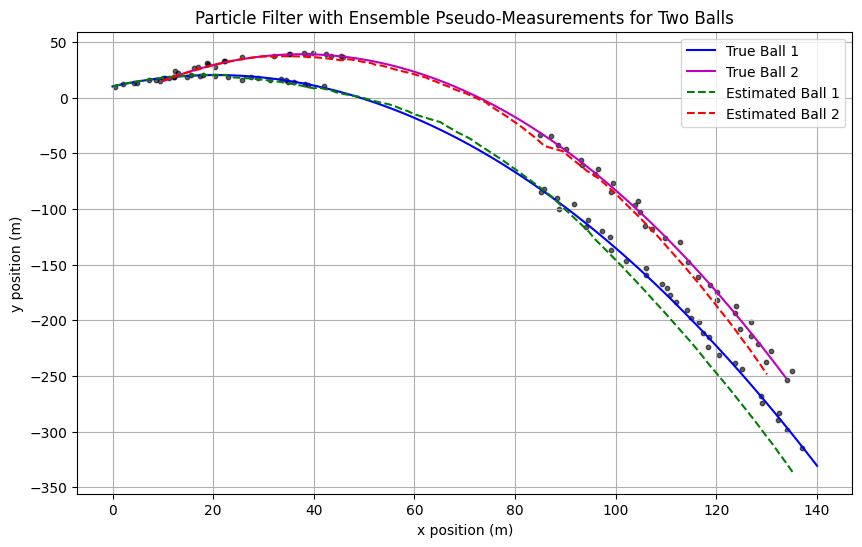

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings for regression models
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def simulate_particle_filter_with_ensemble_pseudo_measurements(
    x0_1, y0_1, vx0_1, vy0_1,
    x0_2, y0_2, vx0_2, vy0_2,
    Q, R, observation_probability,
    dropout_start, dropout_end,
    num_steps, num_particles, dt,
    num_pseudo_samples=50,
    steps_per_growth=5,    # Number of steps before increasing uncertainty
    growth_factor=2.0,     # Factor by which uncertainty increases
    window_size=5,
    poly_degree=2
):
    """
    Modified Particle Filter that uses Ensemble Pseudo-Measurements during dropouts.
    """
    g = 9.81

    dim = 8  # [x1,y1,vx1,vy1,x2,y2,vx2,vy2]
    true_states = np.zeros((num_steps, dim))
    true_states[0] = [x0_1, y0_1, vx0_1, vy0_1, x0_2, y0_2, vx0_2, vy0_2]

    # Generate true trajectory
    for t in range(1, num_steps):
        x1, y1, vx1, vy1, x2, y2, vx2, vy2 = true_states[t-1]
        x1_new = x1 + vx1 * dt
        y1_new = y1 + vy1 * dt - 0.5 * g * dt**2
        vx1_new = vx1
        vy1_new = vy1 - g * dt

        x2_new = x2 + vx2 * dt
        y2_new = y2 + vy2 * dt - 0.5 * g * dt**2
        vx2_new = vx2
        vy2_new = vy2 - g * dt

        true_states[t] = [x1_new, y1_new, vx1_new, vy1_new, x2_new, y2_new, vx2_new, vy2_new]

    # Generate observations
    observations = [[] for _ in range(num_steps)]
    for t in range(num_steps):
        if not (dropout_start <= t < dropout_end):
            x1, y1, _, _, x2, y2, _, _ = true_states[t]
            if np.random.rand() < observation_probability:
                obs_1 = [x1 + np.random.randn()*np.sqrt(R[0,0]),
                         y1 + np.random.randn()*np.sqrt(R[1,1])]
                observations[t].append(('ball1', obs_1))
            if np.random.rand() < observation_probability:
                obs_2 = [x2 + np.random.randn()*np.sqrt(R[0,0]),
                         y2 + np.random.randn()*np.sqrt(R[1,1])]
                observations[t].append(('ball2', obs_2))

    # Initialize particles
    particles = np.zeros((num_particles, dim))
    particles[:,0] = x0_1 + np.random.randn(num_particles)
    particles[:,1] = y0_1 + np.random.randn(num_particles)
    particles[:,2] = vx0_1 + np.random.randn(num_particles)
    particles[:,3] = vy0_1 + np.random.randn(num_particles)
    particles[:,4] = x0_2 + np.random.randn(num_particles)
    particles[:,5] = y0_2 + np.random.randn(num_particles)
    particles[:,6] = vx0_2 + np.random.randn(num_particles)
    particles[:,7] = vy0_2 + np.random.randn(num_particles)

    # Store particles and weights at each time
    particle_history = np.zeros((num_steps, num_particles, dim))
    weights_history = np.zeros((num_steps, num_particles))

    # Initial step: uniform weights
    weights = np.ones(num_particles)/num_particles
    particle_history[0] = particles
    weights_history[0] = weights

    # Initialize variables for pseudo-measurements
    times = [0]
    x1_history = [particles[:,0].mean()]
    y1_history = [particles[:,1].mean()]
    x2_history = [particles[:,4].mean()]
    y2_history = [particles[:,5].mean()]

    # Initialize regression models for both balls
    # For Ball 1
    gpr_x1 = None
    gpr_y1 = None
    gpr_fitted_x1 = False
    gpr_fitted_y1 = False

    linear_model_x1 = LinearRegression()
    linear_model_y1 = LinearRegression()

    # For Ball 2
    gpr_x2 = None
    gpr_y2 = None
    gpr_fitted_x2 = False
    gpr_fitted_y2 = False

    linear_model_x2 = LinearRegression()
    linear_model_y2 = LinearRegression()

    # Initialize dropout counters and noise scaling factors for both balls
    dropout_counter_x1 = 0
    dropout_counter_y1 = 0
    dropout_counter_x2 = 0
    dropout_counter_y2 = 0

    noise_scaling_factor_x1 = 1.0
    noise_scaling_factor_y1 = 1.0
    noise_scaling_factor_x2 = 1.0
    noise_scaling_factor_y2 = 1.0

    # Ensemble parameters
    ensemble_size = 3  # GPR, Polynomial, Linear
    poly_degree = 2

    for t in range(1, num_steps):
        # Prediction Step
        # Update particles based on motion model
        particles[:, 0] += particles[:, 2] * dt
        particles[:, 1] += particles[:, 3] * dt - 0.5 * g * dt**2
        particles[:, 3] -= g * dt

        particles[:, 4] += particles[:, 6] * dt
        particles[:, 5] += particles[:, 7] * dt - 0.5 * g * dt**2
        particles[:, 7] -= g * dt

        # Add process noise
        particles += np.random.multivariate_normal(np.zeros(dim), Q, size=num_particles)

        # Get current observations
        current_obs = observations[t]

        # Initialize lists to hold pseudo-measurements for both balls
        pseudo_measurements = {'ball1': None, 'ball2': None}

        if len(current_obs) > 0:
            # If there are real observations, process them normally
            # Assign observations to respective balls
            for obs in current_obs:
                ball, measurement = obs
                d = np.sum((particles[:, [0,1]] - measurement)**2, axis=1) if ball == 'ball1' else np.sum((particles[:, [4,5]] - measurement)**2, axis=1)
                w = np.exp(-d / (2 * R[0,0]))
                weights *= w
        else:
            # No real observations, check if in dropout period
            if dropout_start <= t < dropout_end:
                # For Ball 1
                # Update dropout counter
                dropout_counter_x1 += 1
                dropout_counter_y1 += 1

                # Increase noise scaling factor
                if dropout_counter_x1 % steps_per_growth == 0:
                    noise_scaling_factor_x1 *= growth_factor
                if dropout_counter_y1 % steps_per_growth == 0:
                    noise_scaling_factor_y1 *= growth_factor

                # Generate pseudo-measurements for Ball 1
                if len(times) >= window_size:
                    # Prepare training data
                    T_train = np.array(times).reshape(-1,1)
                    x_train = np.array(x1_history)
                    y_train = np.array(y1_history)

                    # Fit GPR for Ball 1
                    if not gpr_fitted_x1:
                        kernel = 1.0 * RBF(length_scale=10.0) + WhiteKernel(noise_level=1e-3)
                        gpr_x1 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
                        gpr_y1 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
                        gpr_x1.fit(T_train, x_train)
                        gpr_y1.fit(T_train, y_train)
                        gpr_fitted_x1 = True

                    # Fit Polynomial Regression for Ball 1
                    px1 = np.polyfit(T_train.flatten(), x_train, poly_degree)
                    py1 = np.polyfit(T_train.flatten(), y_train, poly_degree)

                    # Fit Linear Regression for Ball 1
                    linear_model_x1.fit(T_train, x_train)
                    linear_model_y1.fit(T_train, y_train)

                    # Predict using GPR
                    x_gpr_mean1, _ = gpr_x1.predict([[t]], return_std=True)
                    y_gpr_mean1, _ = gpr_y1.predict([[t]], return_std=True)

                    # Predict using Polynomial Regression
                    x_poly1 = np.polyval(px1, t)
                    y_poly1 = np.polyval(py1, t)

                    # Predict using Linear Regression
                    x_lin1 = linear_model_x1.predict([[t]])[0]
                    y_lin1 = linear_model_y1.predict([[t]])[0]

                    # Ensemble Prediction for Ball 1
                    x_ens1 = (x_gpr_mean1[0] + x_poly1 + x_lin1) / ensemble_size
                    y_ens1 = (y_gpr_mean1[0] + y_poly1 + y_lin1) / ensemble_size

                    # Add noise based on scaling factor
                    pseudo_measurements['ball1'] = np.array([x_ens1, y_ens1]) + \
                        np.random.multivariate_normal([0,0], R * noise_scaling_factor_x1)

                # Repeat the same for Ball 2
                # Update dropout counter
                dropout_counter_x2 += 1
                dropout_counter_y2 += 1

                # Increase noise scaling factor
                if dropout_counter_x2 % steps_per_growth == 0:
                    noise_scaling_factor_x2 *= growth_factor
                if dropout_counter_y2 % steps_per_growth == 0:
                    noise_scaling_factor_y2 *= growth_factor

                if len(times) >= window_size:
                    # Prepare training data
                    T_train = np.array(times).reshape(-1,1)
                    x_train = np.array(x2_history)
                    y_train = np.array(y2_history)

                    # Fit GPR for Ball 2
                    if not gpr_fitted_x2:
                        kernel = 1.0 * RBF(length_scale=10.0) + WhiteKernel(noise_level=1e-3)
                        gpr_x2 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
                        gpr_y2 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
                        gpr_x2.fit(T_train, x_train)
                        gpr_y2.fit(T_train, y_train)
                        gpr_fitted_x2 = True

                    # Fit Polynomial Regression for Ball 2
                    px2 = np.polyfit(T_train.flatten(), x_train, poly_degree)
                    py2 = np.polyfit(T_train.flatten(), y_train, poly_degree)

                    # Fit Linear Regression for Ball 2
                    linear_model_x2.fit(T_train, x_train)
                    linear_model_y2.fit(T_train, y_train)

                    # Predict using GPR
                    x_gpr_mean2, _ = gpr_x2.predict([[t]], return_std=True)
                    y_gpr_mean2, _ = gpr_y2.predict([[t]], return_std=True)

                    # Predict using Polynomial Regression
                    x_poly2 = np.polyval(px2, t)
                    y_poly2 = np.polyval(py2, t)

                    # Predict using Linear Regression
                    x_lin2 = linear_model_x2.predict([[t]])[0]
                    y_lin2 = linear_model_y2.predict([[t]])[0]

                    # Ensemble Prediction for Ball 2
                    x_ens2 = (x_gpr_mean2[0] + x_poly2 + x_lin2) / ensemble_size
                    y_ens2 = (y_gpr_mean2[0] + y_poly2 + y_lin2) / ensemble_size

                    # Add noise based on scaling factor
                    pseudo_measurements['ball2'] = np.array([x_ens2, y_ens2]) + \
                        np.random.multivariate_normal([0,0], R * noise_scaling_factor_x2)

                # Assign pseudo-measurements
                for ball in ['ball1', 'ball2']:
                    if pseudo_measurements[ball] is not None:
                        measurement = pseudo_measurements[ball]
                        if ball == 'ball1':
                            d = np.sum((particles[:,0:2] - measurement)**2, axis=1)
                        else:
                            d = np.sum((particles[:,4:6] - measurement)**2, axis=1)
                        w = np.exp(-d / (2 * R[0,0]))
                        weights *= w

            # Normalize weights
            weight_sum = np.sum(weights)
            if weight_sum > 0:
                weights /= weight_sum
            else:
                weights = np.ones(num_particles) / num_particles

            # Resample particles based on weights
            indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
            particles = particles[indices]
            weights = np.ones(num_particles) / num_particles  # Reset weights after resampling

        # Update particle history
        particle_history[t] = particles
        weights_history[t] = weights

        # Update history for regression models
        x1_mean = particles[:,0].mean()
        y1_mean = particles[:,1].mean()
        x2_mean = particles[:,4].mean()
        y2_mean = particles[:,5].mean()

        x1_history.append(x1_mean)
        y1_history.append(y1_mean)
        x2_history.append(x2_mean)
        y2_history.append(y2_mean)
        times.append(t)

    # Estimate trajectories as the mean of the particles at each step
    smoothed_estimate = np.mean(particle_history, axis=1)

    # Compute accuracy
    true_ball1 = true_states[:,0:4]
    true_ball2 = true_states[:,4:8]

    sm_ball1 = smoothed_estimate[:,0:4]
    sm_ball2 = smoothed_estimate[:,4:8]

    rmse_ball1 = np.sqrt(np.mean(np.sum((true_ball1[:,0:2]-sm_ball1[:,0:2])**2, axis=1)))
    rmse_ball2 = np.sqrt(np.mean(np.sum((true_ball2[:,0:2]-sm_ball2[:,0:2])**2, axis=1)))

    range_ball1 = np.max(true_ball1[:,0:2]) - np.min(true_ball1[:,0:2])
    range_ball2 = np.max(true_ball2[:,0:2]) - np.min(true_ball2[:,0:2])

    accuracy_ball1 = 100*(1 - rmse_ball1/range_ball1) if range_ball1!=0 else 0
    accuracy_ball2 = 100*(1 - rmse_ball2/range_ball2) if range_ball2!=0 else 0

    print(f'Particle Filter with Ensemble Pseudo-Measurements Accuracy Ball 1: {accuracy_ball1:.2f}%')
    print(f'Particle Filter with Ensemble Pseudo-Measurements Accuracy Ball 2: {accuracy_ball2:.2f}%')

    # Plot results
    plt.figure(figsize=(10,6))
    plt.plot(true_ball1[:,0], true_ball1[:,1], 'b-', label='True Ball 1')
    plt.plot(true_ball2[:,0], true_ball2[:,1], 'm-', label='True Ball 2')
    plt.plot(sm_ball1[:,0], sm_ball1[:,1], 'g--', label='Estimated Ball 1')
    plt.plot(sm_ball2[:,0], sm_ball2[:,1], 'r--', label='Estimated Ball 2')

    # Plot observations
    for t in range(num_steps):
        for obs in observations[t]:
            _, measurement = obs
            plt.scatter(measurement[0], measurement[1], c='k', s=10, alpha=0.6)

    plt.title('Particle Filter with Ensemble Pseudo-Measurements for Two Balls')
    plt.xlabel('x position (m)')
    plt.ylabel('y position (m)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return smoothed_estimate, accuracy_ball1, accuracy_ball2

# Example usage
if __name__ == "__main__":
    # Define initial conditions for Ball 1
    x0_1, y0_1 = 0.0, 10.0
    vx0_1, vy0_1 = 20*np.cos(np.radians(45)), 20*np.sin(np.radians(45))

    # Define initial conditions for Ball 2
    x0_2, y0_2 = 10.0, 15.0
    vx0_2, vy0_2 = 25*np.cos(np.radians(60)), 25*np.sin(np.radians(60))

    # Define covariance matrices
    Q = np.diag([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
    R = np.diag([1.0,1.0])

    # Define simulation parameters
    observation_probability = 0.8
    dropout_start = 30
    dropout_end = 60
    num_steps = 100
    num_particles = 100
    dt = 0.1

    # Run the modified particle filter
    smoothed_estimate, accuracy_ball1, accuracy_ball2 = simulate_particle_filter_with_ensemble_pseudo_measurements(
        x0_1, y0_1, vx0_1, vy0_1,
        x0_2, y0_2, vx0_2, vy0_2,
        Q, R, observation_probability,
        dropout_start, dropout_end,
        num_steps, num_particles, dt,
        num_pseudo_samples=50,
        steps_per_growth=10,
        growth_factor=3.4,
        window_size=5,
        poly_degree=2
    )


**method2:**


---

This Python script implements a forward-backward particle filter to track two projectiles. It estimates the trajectory of particles using forward filtering and backward smoothing. The particles are updated with process noise and resampled based on observations. During smoothing, particle lineages are traced backward to generate multiple possible trajectories. It evaluates accuracy for both projectiles and visualizes true paths, observations, and smoothed estimates.

Forward-Backward Particle Smoothing Accuracy Ball 1: 98.82%
Forward-Backward Particle Smoothing Accuracy Ball 2: 99.16%


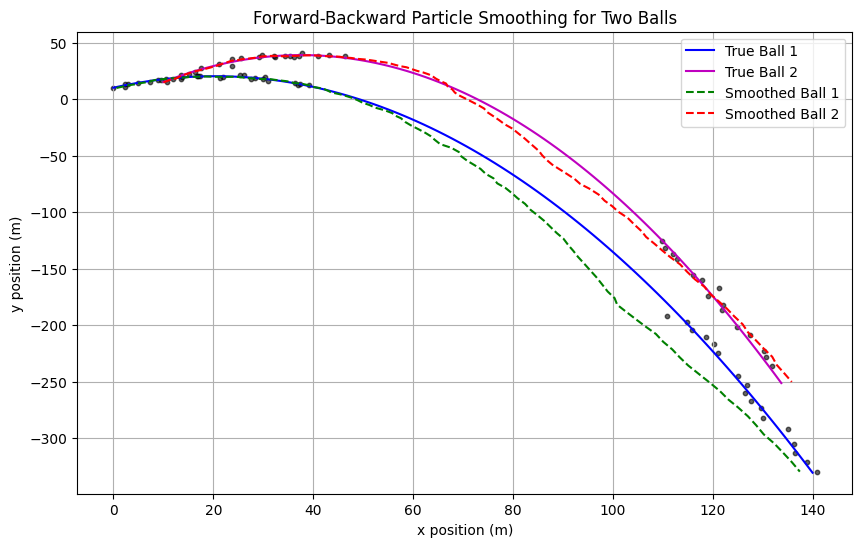

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_particle_filter_forward_backward(
    x0_1, y0_1, vx0_1, vy0_1,
    x0_2, y0_2, vx0_2, vy0_2,
    Q, R, observation_probability,
    dropout_start, dropout_end,
    num_steps, num_particles, dt,
    num_smoothing_samples=50
):
    g = 9.81

    dim = 8  # [x1,y1,vx1,vy1,x2,y2,vx2,vy2]
    true_states = np.zeros((num_steps, dim))
    true_states[0] = [x0_1, y0_1, vx0_1, vy0_1, x0_2, y0_2, vx0_2, vy0_2]

    # Generate true trajectory
    for t in range(1, num_steps):
        x1, y1, vx1, vy1, x2, y2, vx2, vy2 = true_states[t-1]
        x1_new = x1 + vx1 * dt
        y1_new = y1 + vy1 * dt - 0.5*g*dt**2
        vx1_new = vx1
        vy1_new = vy1 - g*dt

        x2_new = x2 + vx2 * dt
        y2_new = y2 + vy2 * dt - 0.5*g*dt**2
        vx2_new = vx2
        vy2_new = vy2 - g*dt

        true_states[t] = [x1_new, y1_new, vx1_new, vy1_new, x2_new, y2_new, vx2_new, vy2_new]

    # Generate observations
    observations = [[] for _ in range(num_steps)]
    for t in range(num_steps):
        if not (dropout_start <= t < dropout_end):
            x1, y1, _, _, x2, y2, _, _ = true_states[t]
            if np.random.rand() < observation_probability:
                obs_1 = [x1 + np.random.randn()*np.sqrt(R[0,0]),
                         y1 + np.random.randn()*np.sqrt(R[1,1])]
                observations[t].append(obs_1)
            if np.random.rand() < observation_probability:
                obs_2 = [x2 + np.random.randn()*np.sqrt(R[0,0]),
                         y2 + np.random.randn()*np.sqrt(R[1,1])]
                observations[t].append(obs_2)

    # Initialize particles
    particles = np.zeros((num_particles, dim))
    particles[:,0] = x0_1 + np.random.randn(num_particles)
    particles[:,1] = y0_1 + np.random.randn(num_particles)
    particles[:,2] = vx0_1 + np.random.randn(num_particles)
    particles[:,3] = vy0_1 + np.random.randn(num_particles)
    particles[:,4] = x0_2 + np.random.randn(num_particles)
    particles[:,5] = y0_2 + np.random.randn(num_particles)
    particles[:,6] = vx0_2 + np.random.randn(num_particles)
    particles[:,7] = vy0_2 + np.random.randn(num_particles)

    # Store particles, weights, and ancestor indices at each time
    # after resampling
    particle_history = np.zeros((num_steps, num_particles, dim))
    ancestor_indices = np.zeros((num_steps, num_particles), dtype=int)
    weights_history = np.zeros((num_steps, num_particles))

    # Initial step: uniform weights
    weights = np.ones(num_particles)/num_particles
    particle_history[0] = particles
    weights_history[0] = weights
    ancestor_indices[0] = np.arange(num_particles)

    # Forward filtering
    for t in range(1, num_steps):
        # Prediction
        particles[:, 0] += particles[:, 2]*dt
        particles[:, 1] += particles[:, 3]*dt - 0.5*g*dt**2
        particles[:, 3] -= g*dt

        particles[:, 4] += particles[:, 6]*dt
        particles[:, 5] += particles[:, 7]*dt - 0.5*g*dt**2
        particles[:, 7] -= g*dt

        # Process noise
        particles += np.random.multivariate_normal(np.zeros(dim), Q, size=num_particles)

        current_obs = observations[t]

        if len(current_obs) == 0:
            # No observation, weights remain uniform
            weights = np.ones(num_particles)/num_particles
        elif len(current_obs) == 1:
            obs = current_obs[0]
            # Check ball1 or ball2 assignment
            d_b1 = np.sum((particles[:,0:2]-obs)**2, axis=1)
            w1 = np.exp(-d_b1/(2*R[0,0]))
            d_b2 = np.sum((particles[:,4:6]-obs)**2, axis=1)
            w2 = np.exp(-d_b2/(2*R[0,0]))

            if np.sum(w1) > np.sum(w2):
                w = w1
            else:
                w = w2
            w_sum = np.sum(w)
            weights = w / w_sum if w_sum > 0 else np.ones(num_particles)/num_particles
        else:
            obs1, obs2 = current_obs
            d_b1_A = np.sum((particles[:,0:2]-obs1)**2,axis=1)
            w1_A = np.exp(-d_b1_A/(2*R[0,0]))
            d_b2_A = np.sum((particles[:,4:6]-obs2)**2,axis=1)
            w2_A = np.exp(-d_b2_A/(2*R[0,0]))
            weights_A = w1_A*w2_A

            d_b1_B = np.sum((particles[:,0:2]-obs2)**2,axis=1)
            w1_B = np.exp(-d_b1_B/(2*R[0,0]))
            d_b2_B = np.sum((particles[:,4:6]-obs1)**2,axis=1)
            w2_B = np.exp(-d_b2_B/(2*R[0,0]))
            weights_B = w1_B*w2_B

            if np.sum(weights_A) > np.sum(weights_B):
                w = weights_A
            else:
                w = weights_B

            w_sum = np.sum(w)
            weights = w / w_sum if w_sum > 0 else np.ones(num_particles)/num_particles

        # Resample
        indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
        particles = particles[indices,:]

        # After resampling, weights are uniform again
        weights = np.ones(num_particles)/num_particles
        particle_history[t] = particles
        weights_history[t] = weights
        ancestor_indices[t] = indices

    # Backward simulation particle smoothing
    # We'll generate multiple trajectories and average them
    smoothed_trajectories = np.zeros((num_smoothing_samples, num_steps, dim))
    T = num_steps-1

    # In forward-backward smoothing:
    # Start from the final step by choosing a particle with equal prob (since final weights are uniform after resampling)
    for s in range(num_smoothing_samples):
        i = np.random.choice(np.arange(num_particles))
        smoothed_trajectories[s, T, :] = particle_history[T, i, :]

        # Move backward in time
        # We use ancestor_indices to trace back the chosen particle
        # Since after resampling weights are uniform, ancestor_indices gives us the lineage
        for t in range(T-1, -1, -1):
            i = ancestor_indices[t+1, i]
            smoothed_trajectories[s, t, :] = particle_history[t, i, :]

    # Average smoothed trajectories
    smoothed_estimate = np.mean(smoothed_trajectories, axis=0)

    # Compute accuracy
    true_ball1 = true_states[:,0:4]
    true_ball2 = true_states[:,4:8]

    sm_ball1 = smoothed_estimate[:,0:4]
    sm_ball2 = smoothed_estimate[:,4:8]

    rmse_ball1 = np.sqrt(np.mean(np.sum((true_ball1[:,0:2]-sm_ball1[:,0:2])**2, axis=1)))
    rmse_ball2 = np.sqrt(np.mean(np.sum((true_ball2[:,0:2]-sm_ball2[:,0:2])**2, axis=1)))

    range_ball1 = np.max(true_ball1[:,0:2])-np.min(true_ball1[:,0:2])
    range_ball2 = np.max(true_ball2[:,0:2])-np.min(true_ball2[:,0:2])

    accuracy_ball1 = 100*(1 - rmse_ball1/range_ball1) if range_ball1!=0 else 0
    accuracy_ball2 = 100*(1 - rmse_ball2/range_ball2) if range_ball2!=0 else 0

    print(f'Forward-Backward Particle Smoothing Accuracy Ball 1: {accuracy_ball1:.2f}%')
    print(f'Forward-Backward Particle Smoothing Accuracy Ball 2: {accuracy_ball2:.2f}%')

    # Plot results
    plt.figure(figsize=(10,6))
    plt.plot(true_ball1[:,0], true_ball1[:,1], 'b-', label='True Ball 1')
    plt.plot(true_ball2[:,0], true_ball2[:,1], 'm-', label='True Ball 2')
    plt.plot(sm_ball1[:,0], sm_ball1[:,1], 'g--', label='Smoothed Ball 1')
    plt.plot(sm_ball2[:,0], sm_ball2[:,1], 'r--', label='Smoothed Ball 2')

    # Plot observations
    for t in range(num_steps):
        for obs in observations[t]:
            plt.scatter(obs[0], obs[1], c='k', s=10, alpha=0.6)

    plt.title('Forward-Backward Particle Smoothing for Two Balls')
    plt.xlabel('x position (m)')
    plt.ylabel('y position (m)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return smoothed_estimate, accuracy_ball1, accuracy_ball2

# Example usage
if __name__ == "__main__":
    x0_1, y0_1 = 0.0, 10.0
    vx0_1, vy0_1 = 20*np.cos(np.radians(45)), 20*np.sin(np.radians(45))
    x0_2, y0_2 = 10.0, 15.0
    vx0_2, vy0_2 = 25*np.cos(np.radians(60)), 25*np.sin(np.radians(60))

    Q = np.diag([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
    R = np.diag([1.0,1.0])

    observation_probability = 0.8
    dropout_start = 30
    dropout_end = 80
    num_steps = 100
    num_particles = 500
    dt = 0.1

    simulate_particle_filter_forward_backward(
        x0_1, y0_1, vx0_1, vy0_1,
        x0_2, y0_2, vx0_2, vy0_2,
        Q, R, observation_probability,
        dropout_start, dropout_end,
        num_steps, num_particles, dt,
        num_smoothing_samples=50
    )
